First, we load the data from our feature engineering efforts

In [0]:
%sql
refresh table flights_all_v5

In [0]:
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator

import numpy as np
import matplotlib.pyplot as plt

from pyspark.sql import functions as f
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, NullType, ShortType, DateType, BooleanType, BinaryType, FloatType
from pyspark.sql import SQLContext
from pyspark.conf import SparkConf
from pyspark.sql.functions import hour, minute, second, to_timestamp, monotonically_increasing_id, row_number, lit, pow
from pyspark.sql.window import Window
import urllib.request
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from math import radians
import sklearn.neighbors
import pandas as pd
from sklearn.metrics import pairwise_distances_argmin_min, f1_score, roc_auc_score

from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.feature import PCA, Bucketizer, QuantileDiscretizer
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics, BinaryClassificationMetrics

import itertools

In [0]:
#define some auxiliary evaluation tools for model performance
def calc_f1(predictions):
    '''Utility for calculating F1 score'''
    results = predictions.select(['prediction', 'label'])
    predictionAndLabels=results.rdd
    metrics = MulticlassMetrics(predictionAndLabels)
    precision = metrics.precision(label = 1)
    recall= metrics.recall(label = 1)
    if recall+precision != 0:
        return 2 * recall * precision / (recall + precision)
    return 0
  
def evaluate_test(model, df):
    '''Utility for evaluating model performance'''
    predictions = model.transform(df)
    #predictions = predictions.withColumn('label', f.col('label'))
    evaluator = BinaryClassificationEvaluator()
    #return evaluator.evaluate(predictions)
    return calc_f1(predictions), evaluator.evaluate(predictions)

In [0]:
data = spark.sql("SELECT * FROM flights_all_v5 ORDER BY FL_DATE, CRS_DEP_TIME")
data.registerTempTable('flights_all')

#Generate index for ordered flights
df = data.withColumn("mono_index", f.monotonically_increasing_id())
df = df.withColumn("vis_var_code", df["vis_var_code"].cast(StringType()))

In [0]:
#Generate train/test split as before in the Feature Engineering notebook
count = df.count()
train = df.limit(int(0.9*count))
test = df.orderBy(f.desc("mono_index")).drop("mono_index").limit(count-int(0.9*count))

### Data Assembly

First, we process the data to be suitable for PySpark ML, which requires all features to be collected in a vector. We define our list of variables into three types:

1. Numeric variables
2. Categorical variables represented as a string
3. Categorical variables represented as an int

Variables of the first type will be scaled so that Logistic Regression, which minimizes with gradient descent, can run more efficiently with less of a chance to diverge. Categorical variables as strings will first generate integer indicators for each string, and along with categorical variables also as an int, will be one-hot encoded for our models.

In addition to assembly, we generate a weights column that represents the weight of the sample. This helps with training for unbalanced classes as most flights are not delayed in this dataset. By up-weighing the delayed flights, we place more an emphasis on these flights, increasing the loss associated with these flights in order to balance out the effect of having less examples.

We also generate two train/test sets: a smaller one (with the first 500k examples, 50k of which is test), and on the full dataset (a 90/10 split)

In [0]:
#Define the types of features we take
int_categorical = ['DAY_OF_WEEK', 'DEP_DEL15_PREV', 'MONTH', 'QUARTER', 'DAY_OF_MONTH', 'OD_GROUP', 'OP_CARRIER_FL_NUM_bucket', 'CRS_DEP_TIME_bucket', 'ORIGIN_bucket', 'DEST_bucket', 'ORIGIN_STATE_ABR_bucket', 'DEST_STATE_ABR_bucket', 'DISTANCE_GROUP']

str_features = ['cig_code','cig_cavok_code','dest_cig_code','dest_cig_cavok_code','vis_var_code', 'dest_vis_var_code'] 

#Categorical features
categorical_features = int_categorical + str_features

num_features = ["DISTANCE", 'vis_distance', 'tmp', 'dew', 'elevation', 'dest_wnd_speed', 'pagerank', 'pagerank_dest', 'wnd_speed', 'cig_height', 'dest_vis_distance', 'dest_tmp', 'dest_dew', 'dest_elevation', 'dest_cig_height','wnd_direction'] 

#Total number of features
num_features_total = len(int_categorical) + len(str_features) + len(num_features)

#Indexers for string categories
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").setHandleInvalid('keep').fit(df) for column in str_features]

#columns for categorical variables
input_cols = [i+'_index' for i in str_features] + int_categorical
output_cols = [i+'_ohe' for i in input_cols]

#one hot encode all categorical variables
encoder = OneHotEncoder(inputCols=input_cols,
                        outputCols=output_cols)

#assembled pipeline
assembler_inputs = output_cols + num_features
label_stringIdx = StringIndexer(inputCol="DEP_DEL15", outputCol="label")

# scaler for numeric variables
num_assembler = VectorAssembler(inputCols=num_features, outputCol='num_features')
df = VectorAssembler(inputCols=num_features , outputCol='num_features').transform(df)
scaled_data = StandardScaler(inputCol='num_features', outputCol="scaled_num_features", withStd=True, withMean=True)\
                            .fit(df.limit(int(0.9*count)))\
                            .transform(df)

#total vector assembler
assembler = VectorAssembler(inputCols=['scaled_num_features'] + output_cols, outputCol='features')

#define the pipeline
stages = indexers + [encoder, label_stringIdx, assembler]

#final E-to-E pipeline
pipeline = Pipeline(stages=stages)
assembled = pipeline.fit(scaled_data).transform(scaled_data)

#Select the subset of data to work with

#small set to test with
small_train = assembled.limit(450000)
small_test = assembled.orderBy(f.desc("mono_index")).drop("mono_index").limit(50000)

#generate a column of weights for logistic regression / random forest
num_delayed = small_train.filter(f.col('label') == 1).count()
num_on_time = small_train.filter(f.col('label') == 0).count()

weight_col = f.expr("""IF(label == 1, %f, %f)""" %(num_on_time/(num_on_time+num_delayed), 1-num_on_time/(num_on_time+num_delayed)))
small_train = small_train.withColumn('weight', weight_col)


#full dataset
train = assembled.limit(int(0.9*count)).select('features', 'label')
test = assembled.orderBy(f.desc("mono_index")).drop("mono_index").limit(count-int(0.9*count)).select('features', 'label')

#generate a column of weights for logistic regression / random forest
num_delayed = train.filter(f.col('label') == 1).count()
num_on_time = train.filter(f.col('label') == 0).count()

weight_col = f.expr("""IF(label == 1, %f, %f)""" %(num_on_time/(num_on_time+num_delayed), 1-num_on_time/(num_on_time+num_delayed)))
train = small_train.withColumn('weight', weight_col)

### Feature Selection

#### PCA 
In order to perform feature selection, we started with PCA in order to see if we can find a smaller number of PCs than the number of features we have. The goal is to perform just as well as using all of the features. To do this, we perform a PCA analysis, and take the top n components, ranging n from 1 to the total number of features, and train a Logistic Regression model. By training on the small train and evaluating on the test, we try and see if we can find an optimal point in terms of performance.

In [0]:
#PCA featurization procedure depending on the number of PCs to return
def pca_featurization(train_df, test_df, size = 2):
    pca = PCA(k=size, inputCol="features", outputCol="pca")
    pca_model = pca.fit(train_df)
    train_pca = pca_model.transform(train_df)
    test_pca = pca_model.transform(test_df)
    return train_pca, test_pca

In [0]:
num_features_total = len(feature_list_importance)

train_auc, test_auc = [], []

#training proocedure
def log_reg_pca_featurization(train, test):
    for i in range(1, num_features_total+1):
        train_pca, test_pca = pca_featurization(train, test, i)
        lr = LogisticRegression(maxIter=1000, regParam=0.3, elasticNetParam=0.0, featuresCol = 'pca', labelCol='DEP_DEL15', weights = 'weights')
        lr_model = lr.fit(train_pca)
        tr_auc = evaluate_test(lr_model, train_pca)
        te_auc = evaluate_test(lr_model, test_pca)
        train_auc.append(tr_auc)
        test_auc.append(te_auc)
        print("PCA components: %d" %i, tr_auc, te_auc)
        
tr = train.select('features', 'DEP_DEL15')
te = test.select('features', 'DEP_DEL15')
log_reg_pca_featurization(tr, te)

Out[46]:

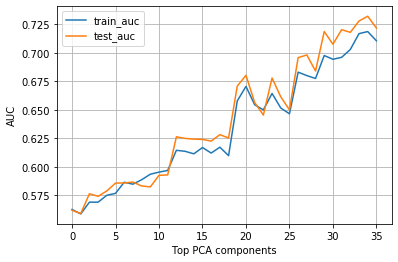

<matplotlib.legend.Legend at 0x7f65b599e710>

In [0]:
#partial training set
plt.plot(train_auc, label = 'train_auc')
plt.plot(test_auc, label = 'test_auc')
plt.grid()
plt.xlabel('Top PCA components')
plt.ylabel('AUC')
plt.legend()

The plot above shows that as more PCs are added up to the maximum number, the performance for both train and test increases, indicating we have not found an optimal number of PCs (all of them seem to add value). As a result, we'll take a second procedure with Random Forests.

#### Random Forest Model

Random Forest models have a natural way to derive feature importance based on the average information gain for each feature when that feature is used for a split. Here, we train an RF model on the full dataset to get feature importance, and then see if we can eliminate some features (on the smaller data set) and still get just as good performance.

For the large dataset, the partition size can really matter. Typically, a recommended setting is 2-4 partitions for each CPU on the cluster. We're working on a CPU of size 8, so setting this to 24.

In [0]:
train = train.coalesce(24)
test = test.coalesce(24)

In [0]:
#train the RF model on the full dataset
rf = RandomForestClassifier(featuresCol = 'features', labelCol='label', weightCol='weight')
rf_model = rf.fit(train)
print(evaluate_test(rf_model, train), evaluate_test(rf_model, test))

(0.43011972924698416, 0.7218300462300727) (0.4197744954201533, 0.7149890603339848)

We see that the F1 score (first entry) and AUC (second entry) for train and test are pretty similar. Below, we extract the feature importance vector.

In [0]:
#full dataset
feature_importances = np.array(rf_model.featureImportances)
not_selected = (feature_importances == 0)
selected = (feature_importances != 0)

features_df = pd.DataFrame(train.schema["features"].metadata["ml_attr"]["attrs"]["binary"]+train.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]).sort_values("idx")

sorted_features = sorted(zip(features_df.name, feature_importances), key = lambda x: -x[1])

def sort_features(features):
  if 'scaled_num_features' in features:
    return num_features[int(features.split('_')[-1])]
  feats = features.split('_')
  if len(feats) > 2:
    feats = [i for i in feats if i != 'ohe']
    return '_'.join(feats[:-1])
  else:
    return features
  
feature_list_importance = list(pd.Series([sort_features(i[0]) for i in sorted_features]).drop_duplicates().values)
print(feature_list_importance)

Out[20]: ['DEP_DEL15_PREV',
 'CRS_DEP_TIME_bucket',
 'OD_GROUP',
 'wnd_speed',
 'vis_distance',
 'dest_tmp',
 'tmp',
 'dew',
 'ORIGIN_STATE_ABR_bucket',
 'dest_wnd_speed',
 'ORIGIN_bucket',
 'MONTH',
 'DEST_STATE_ABR_bucket',
 'dest_cig_height',
 'elevation',
 'dest_vis_distance',
 'pagerank',
 'cig_height',
 'OP_CARRIER_FL_NUM_bucket',
 'DISTANCE',
 'dest_dew',
 'DEST_bucket',
 'DISTANCE_GROUP',
 'DAY_OF_WEEK',
 'DAY_OF_MONTH',
 'cig_code_index',
 'dest_cig_code_index',
 'pagerank_dest',
 'vis_var_code_index',
 'dest_elevation',
 'wnd_direction',
 'cig_cavok_code_index',
 'dest_cig_cavok_code_index',
 'dest_vis_var_code_index',
 'QUARTER']

In [0]:
feature_importance_list = ['DEP_DEL15_PREV',
 'CRS_DEP_TIME_bucket',
 'OD_GROUP',
 'wnd_speed',
 'vis_distance',
 'dest_tmp',
 'tmp',
 'dew',
 'ORIGIN_STATE_ABR_bucket',
 'dest_wnd_speed',
 'ORIGIN_bucket',
 'MONTH',
 'DEST_STATE_ABR_bucket',
 'dest_cig_height',
 'elevation',
 'dest_vis_distance',
 'pagerank',
 'cig_height',
 'OP_CARRIER_FL_NUM_bucket',
 'DISTANCE',
 'dest_dew',
 'DEST_bucket',
 'DISTANCE_GROUP',
 'DAY_OF_WEEK',
 'DAY_OF_MONTH',
 'cig_code',
 'dest_cig_code',
 'pagerank_dest',
 'vis_var_code',
 'dest_elevation',
 'wnd_direction',
 'cig_cavok_code',
 'dest_cig_cavok_code',
 'dest_vis_var_code',
 'QUARTER']

The features above make sense in terms of importance. The best variable is whether the previous flight on the same plane was delayed. The second is the depature time. We expect more delays say later in the day than earlier in the day. The least important variables are the codes associated with CIG, VIS, and related weather variables. These are mostly redundant as they are either classifications of a numeric variable, or they represent quality of the data. These should not directly have a relationship with delay. 

Below, we rigorously test to see which set of features are the best. We start by generating an RF model for the top 5 features, followed by top 6 features, etc. on the smaller dataset. If we reach an optimum before getting to all of the features, we can narrow down the useful features for the full model.

In [0]:
#RF search by eliminating worst features
def get_features_df(df, feature_list_importance, top_n, set = 'small'):
    df = df.select(feature_list_importance + ['DEP_DEL15'])
    wanted_features = feature_list_importance[:top_n]
    int_categorical = ['DAY_OF_WEEK', 'DEP_DEL15_PREV', 'MONTH', 'QUARTER', 'DAY_OF_MONTH', 'OD_GROUP', 'OP_CARRIER_FL_NUM_bucket', 'CRS_DEP_TIME_bucket', 'ORIGIN_bucket', 'DEST_bucket', 'ORIGIN_STATE_ABR_bucket', 'DEST_STATE_ABR_bucket', 'DISTANCE_GROUP']

    str_features = ['cig_code','cig_cavok_code','dest_cig_code','dest_cig_cavok_code','vis_var_code', 'dest_vis_var_code'] 

    #Categorical features
    categorical_features = int_categorical + str_features

    num_features = ["DISTANCE", 'vis_distance', 'tmp', 'dew', 'elevation', 'dest_wnd_speed', 'pagerank', 'pagerank_dest', 'wnd_speed', 'cig_height', 'dest_vis_distance', 'dest_tmp', 'dest_dew', 'dest_elevation', 'dest_cig_height','wnd_direction'] 

    #Total number of features
    num_features_total = len(int_categorical) + len(str_features) + len(num_features)

    
    #Filter just down to the set of unwanted features
    int_categorical = [i for i in int_categorical if i in wanted_features]
    str_features = [i for i in str_features if i in wanted_features]
    num_features = [i for i in num_features if i in wanted_features]
    
    
    #Indexers for string categories
    indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").setHandleInvalid('keep').fit(df) for column in str_features]

    #columns for categorical variables
    input_cols = [i+'_index' for i in str_features] + int_categorical
    output_cols = [i+'_ohe' for i in input_cols]

    encoder = OneHotEncoder(inputCols=input_cols,
                            outputCols=output_cols)

    assembler_inputs = output_cols + num_features
    label_stringIdx = StringIndexer(inputCol="DEP_DEL15", outputCol="label")

    # scaler for numeric variables
    num_assembler = VectorAssembler(inputCols=num_features, outputCol='num_features')
    df = VectorAssembler(inputCols=num_features , outputCol='num_features').transform(df)
    scaled_data = StandardScaler(inputCol='num_features', outputCol="scaled_num_features", withStd=True, withMean=True)\
                                .fit(df.limit(int(0.9*count)))\
                                .transform(df)

    #total vector assembler
    assembler = VectorAssembler(inputCols=['scaled_num_features'] + output_cols, outputCol='features')

    #define the pipeline
    stages = indexers + [encoder, label_stringIdx, assembler]

    pipeline = Pipeline(stages=stages)
    assembled = pipeline.fit(scaled_data).transform(scaled_data)


    df_transformed = assembled

    if set == 'small':
      #Select the subset of data to work with
      train = df_transformed.limit(450000)
      test = df_transformed.orderBy(f.desc("mono_index")).drop("mono_index").limit(50000)

      #generate a column of weights for logistic regression
      num_delayed = train.filter(f.col('label') == 1).count()
      num_on_time = train.filter(f.col('label') == 0).count()

      weight_col = f.expr("""IF(label == 1, %f, %f)""" %(num_on_time/(num_on_time+num_delayed), 1-num_on_time/(num_on_time+num_delayed)))
      train = train.withColumn('weight', weight_col)
      
    else:
      train = df_transformed.limit(int(0.9*count)).select('features', 'label')
      test = df_transformed.orderBy(f.desc("mono_index")).drop("mono_index").limit(count-int(0.9*count)).select('features', 'label')
      
      #generate a column of weights for logistic regression
      num_delayed = train.filter(f.col('label') == 1).count()
      num_on_time = train.filter(f.col('label') == 0).count()

      weight_col = f.expr("""IF(label == 1, %f, %f)""" %(num_on_time/(num_on_time+num_delayed), 1-num_on_time/(num_on_time+num_delayed)))
      train = train.withColumn('weight', weight_col)
      
    return train, test

def train_model(train, test, model = 'RF'):
    if model == 'RF':
        model = RandomForestClassifier(featuresCol = 'features', labelCol='DEP_DEL15', weightCol='weight')
    else:
        model = LogisticRegression(maxIter=1000, regParam=0.3, elasticNetParam=0.0, featuresCol = 'features', labelCol='DEP_DEL15', weightCol='weight')
        
    model = model.fit(train)
    train_auc_val = evaluate_test(model, train)
    test_auc_val = evaluate_test(model, test)
    return model, train_auc_val, test_auc_val
    
models, train_auc, test_auc = [], [], []
def main(feature_list_importance):
    for i in range(5, len(feature_list_importance) + 1):
        train_df, test_df = get_features_df(df, feature_list_importance, i)
        lr_model, train_auc_val, test_auc_val = train_model(train_df, test_df)
        models.append(lr_model)
        train_auc.append(train_auc_val)
        test_auc.append(test_auc_val)
        print(train_auc_val, test_auc_val)

Out[17]:

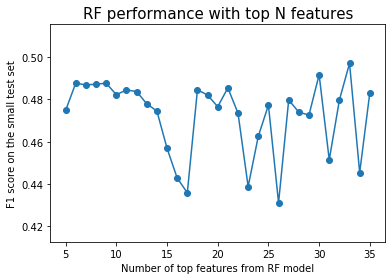

Text(0, 0.5, 'F1 score on the small test set')

In [0]:
#Test set results of this scan, F1 and AUC
test_f1_auc = [(0.4748165495706479, 0.7106082826028781),
 (0.4877781831448376, 0.7083867733864853),
 (0.4868786386027766, 0.7117872419457814),
 (0.48726560313462075, 0.706969347371117),
 (0.4876973595429805, 0.7057778046184543),
 (0.4822791096663506, 0.7083718104074951),
 (0.4845210151025289, 0.7048681236099683),
 (0.4837574816100882, 0.6977149693330588),
 (0.47795453538352467, 0.6978115564018372),
 (0.4745262575499101, 0.7037773266434946),
 (0.45688009717161204, 0.7053181408423859),
 (0.4428039091612177, 0.7151142191902248),
 (0.43576036051957234, 0.7118413583479897),
 (0.48461538461538456, 0.708586785468326),
 (0.48207955888144943, 0.7061227824460443),
 (0.4765797826296047, 0.7116751600333282),
 (0.4854816824966079, 0.707926033717824),
 (0.4735288516473053, 0.7113673585519251),
 (0.4387271807605647, 0.7122779473793381),
 (0.46254526416823005, 0.6963932391537581),
 (0.47732589526723057, 0.6956413074411308),
 (0.43103627481550777, 0.6931810584325695),
 (0.4797740437550865, 0.7062889276848121),
 (0.4739768043707467, 0.7025243795049875),
 (0.47262747363859603, 0.7001355463226895),
 (0.49171937264651044, 0.7147771408247915),
 (0.45139802852461663, 0.7076470922535373),
 (0.47975193224418006, 0.7057038743217336),
 (0.49711934156378595, 0.7093869001405632),
 (0.4453600435698894, 0.7176739246830596),
 (0.48318154775525146, 0.694799903040958)]

plt.scatter(range(5, len(test_f1_auc) +5), [i[0] for i in test_f1_auc])
plt.plot(range(5, len(test_f1_auc) +5), [i[0] for i in test_f1_auc])

plt.title("RF performance with top N features", fontsize = 15)
plt.xlabel("Number of top features from RF model")
plt.ylabel("F1 score on the small test set")

In [0]:
#Top F1 score overall
print("Num features achieving top F1 score overall: %d at F1 of %f" %(np.argmax([i[0] for i in test_f1_auc]) + 5, test_f1_auc[np.argmax([i[0] for i in test_f1_auc]) ][0]))

#Top F1 core with less than 20 features
print("Num features (less than 20) achieving top F1 score overall: %d at F1 of %f" %(np.argmax([i[0] for i in test_f1_auc[:20]]) + 5, test_f1_auc[np.argmax([i[0] for i in test_f1_auc[:20]]) ][0]))


Num features achieving top F1 score overall: 33 at F1 of 0.497119
Num features (less than 20) achieving top F1 score overall: 6 at F1 of 0.487778

Based on the analysis above, we do similarly on the top 6 features than on the full dataset. We'll try using the top 6 features on the full dataset.

### Performance on the entire dataset

We now evaluate performance on the entire dataset using the selected features from above with both Logistic Regression and Random Forest.

In [0]:
#Get dfs 
top_6_train, test_6_test = get_features_df(df, feature_importance_list, 6, set = 'full')

In [0]:
top_6_train.count()

Out[66]: 27766340

##### Logistic Regression

In [0]:
#Train on the full dataset with top 6 features
lr = LogisticRegression(maxIter=1000, regParam=0.3, elasticNetParam=0, featuresCol = 'features', labelCol='label', weightCol='weight')
lr_model_6 = lr.fit(top_6_train)
print(evaluate_test(lr_model_6, top_6_train), evaluate_test(lr_model_6, test_6_test))

(0.4215711128713713, 0.7233230891700703) (0.40971807293150836, 0.7180464642387843)

By default, the threshold is set at 0.5 for predicting a positive example. We can easily see if a couple of neighboring thresholds perform better than 0.5. By setting the threshold a bit higher at 0.55, we can get even better performance in terms of F1 (0.440 vs 0.410). The same observation was seen for the smaller dataset (0.55 gave the best performance there as well).

In [0]:
#We can test two neighboring thresholds
train_scores, test_scores = [], []

for i in [0.45, 0.55]:
    lr_model_6.setThreshold(i)
    train_scores.append(evaluate_test(lr_model_6, top_6_train))
    test_scores.append(evaluate_test(lr_model_6, test_6_test))
    print(train_scores[-1], test_scores[-1])

(0.3759505608169132, 0.7226344987176578) (0.3564299231359266, 0.7180464642387843)
(0.4471090697077924, 0.7221241466064424) (0.4400996447266077, 0.7180464642387843)

##### Random Forest

In [0]:
#Train on the full dataset with top 6 features
rf = RandomForestClassifier(featuresCol = 'features', labelCol='label', weightCol='weight')
rf_model_6 = rf.fit(top_6_train)
print(evaluate_test(rf_model_6, top_6_train), evaluate_test(rf_model_6, test_6_test))

(0.44287947437136005, 0.7244819717935487) (0.4335428785172293, 0.7179563706555929)

When all of the features were used, the test F1 was 0.420, and we see an improvement by reducing the number of features to the top 6 (0.435). With this as our best model, we generate the full CM below.

#### Final performance confusion matrix

In [0]:
def get_cm(model, test_6_test):
  predictions = rf_model_6.transform(test_6_test)
  results = predictions.select(['prediction', 'label'])
  predictionAndLabels=results.rdd
  metrics = MulticlassMetrics(predictionAndLabels)
  cm = metrics.confusionMatrix().toArray()
  return cm

In [0]:
cm = get_cm(rf_model_6, test_6_test)

Out[71]:

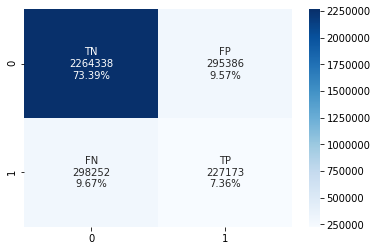

<matplotlib.axes._subplots.AxesSubplot at 0x7f0affab0b10>

In [0]:
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

In [0]:
#Sanity check that we get the same F1
recall = 227173/(227173+298252)
precision = 227173/(227173+295386)
precision * recall / (precision + recall) * 2

Out[78]: 0.4335428785172293